In [149]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm

In [150]:
from astroddpm.diffusion.models.network import DownResBlock, MidResBlock, NormConv2d, sinusoidal_embedding, gaussian_fourier_embedding, SineCosine
from torch.nn import functional as F
from torch import nn

In [151]:
## Relative imports
from astroddpm.runners import config_from_id
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE, ContinuousVPSDE
import astroddpm.utils.colormap_custom 
from astroddpm.datahandler.dataset import get_dataset_and_dataloader
from astroddpm.diffusion.stochastic.sde import get_sde
from astroddpm.diffusion.power_spectra.powerspec_sampler import get_ps_sampler
from astroddpm.utils.scheduler import CosineAnnealingScheduler, LinearScheduler, InversePowerLawScheduler, InverseSquareRootScheduler, StepScheduler

In [152]:
ALL_MODELS = os.path.join(os.path.dirname(astroddpm.__file__), 'config', 'MODELS.json')

with open(ALL_MODELS, 'r') as f:
    ALL_MODELS_DICT = json.load(f)

In [153]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amin = - 3
amax = 6

MODEL_ID = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine'

In [154]:
config = config_from_id(MODEL_ID)

In [155]:
config.keys()

dict_keys(['diffusion_model', 'dataloaders', 'optimizer', 'scheduler', 'ckpt_epoch', 'separate_ckpt', 'ckpt_dir', 'sample_epoch', 'sample_dir', 'sample_size', 'results_size', 'epochs', 'model_id'])

In [156]:
dataloaders_config = config['dataloaders']
power_spectrum_config = config['diffusion_model']['ps']
sde_config = config['diffusion_model']['sde']

In [157]:
train_dataset, test_dataset, train_dataloader, test_dataloader = get_dataset_and_dataloader(dataloaders_config)
train_dataset

In [158]:
ps_sampler = get_ps_sampler(power_spectrum_config)
ps_sampler

CMB_H_OMBH2(
  (emulator): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=128, bias=True)
    )
  )
)

In [159]:
sde = get_sde(sde_config)
sde

In [160]:
class TparamMomentNetwork(nn.Module):
    def __init__(self, in_channels, in_size, dim_param, order, num_blocks, first_channels = 10, time_embed_dim = 100,padding_mode="circular", 
        activation=None, normalize="GN", group_c=1, skiprescale = True, discretization = "continuous", embedding_mode = None, n_steps = 1000,dropout=0.0):
        super().__init__()
        self.in_channels = in_channels
        self.in_size = in_size
        self.first_channels = first_channels
        self.dim_param = dim_param
        self.order = order
        assert self.order <= 2, "Only implemented up to second order moments"
        self.num_blocks = num_blocks
        self.time_embed_dim = time_embed_dim
        self.padding_mode = padding_mode
        self.activation = activation
        self.normalize = normalize
        self.group_c = group_c
        self.skiprescale = skiprescale
        self.discretization = discretization
        self.embedding_mode = embedding_mode
        self.n_steps = n_steps
        self.dropout = dropout

        self.config = {"in_channels": self.in_channels, "in_size": self.in_size, "dim_param": self.dim_param, "order": self.order, "num_blocks": self.num_blocks, 
            "first_channels": self.first_channels, "time_embed_dim": self.time_embed_dim, "padding_mode": self.padding_mode, 
            "activation": self.activation, "normalize": self.normalize, "group_c": self.group_c, "skiprescale": self.skiprescale, "discretization": self.discretization, 
            "embedding_mode": self.embedding_mode, "n_steps": self.n_steps, "dropout": self.dropout}

        if discretization == "discrete":
            self.time_embed = nn.Embedding(n_steps, time_embed_dim)
            self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_embed_dim)
            self.time_embed.requires_grad_(False)
        
        elif discretization == "continuous" or discretization == "default":
            if (embedding_mode is None) or (embedding_mode == "fourier"):
                assert time_embed_dim % 2 == 0, "time_emb_dim must be even for fourier embedding"
                linear1 = nn.Linear(1, time_embed_dim//2)
                linear1.weight.data = gaussian_fourier_embedding(time_embed_dim//2).unsqueeze(1)
                linear1.bias.data = torch.zeros(time_embed_dim//2)
                self.time_embed = nn.Sequential(linear1, SineCosine())
                self.time_embed.requires_grad_(False)
            elif embedding_mode == "forward":
                self.time_embed = nn.Linear(1, time_embed_dim)
        
        self.blocks = nn.ModuleList()
        self.current_channels = self.in_channels
        if self.in_channels != self.first_channels:
            self.head = NormConv2d((self.in_channels, self.in_size, self.in_size),self.in_channels, self.first_channels, kernel_size=1, padding_mode=self.padding_mode, 
                normalize=self.normalize, group_c=self.group_c)
            self.current_channels = self.first_channels
        else:
            self.head = nn.Identity()
        for i in range(self.num_blocks):
            self.blocks.append(DownResBlock(self.in_size, self.current_channels, self.current_channels, padding_mode=self.padding_mode, 
                 normalize=self.normalize, group_c=self.group_c, skiprescale=self.skiprescale))
            
        ## Output dimension will be dim_param ** order
        self.out_dim = self.dim_param ** self.order
        self.fc_tail = nn.Linear(self.current_channels, self.out_dim)

    def forward(self, x, t):
        t = self.time_embed(t)
        x = self.head(x)
        for block in self.blocks:
            x = block(x, t)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = F.dropout(x,p=self.dropout)
        x = self.fc_tail(x)

        if self.order == 1:
            return x
        elif self.order == 2:
            x = x.view(x.size(0), self.dim_param, self.dim_param)
            x = (x + x.transpose(1,2))/2 ## Symmetrize
            return x

In [161]:
class MomentModel(nn.Module):
    def __init__(self, network, sde, ps, conetwork = None):
        super().__init__()
        self.network = network
        self.sde = sde
        self.ps = ps
        self.order = self.network.order
        self.dim_param = self.network.dim_param
        self.config = {"network": self.network.config, "sde": self.sde.config, "ps": self.ps.config}
        self.conetwork = conetwork
        for param in self.ps.parameters():
            param.requires_grad_(False) ## Freeze power spectrum parameters
    def loss(self, batch):
        if isinstance(self.sde, DiscreteVPSDE):
            timesteps = torch.randint(0, self.sde.N, (batch.shape[0],1), device=batch.device)
        else:
            timesteps = torch.rand((batch.shape[0],1), device=batch.device)*(self.sde.tmax - self.sde.tmin) + self.sde.tmin
        ps_tensor, phi = self.ps.sample_ps(batch.shape[0])
        batch_tilde, _ , _ = self.sde.sampling(batch, timesteps, torch.sqrt(ps_tensor))
        rphi = self.ps.rescale_phi(phi)
        out = self.network(batch_tilde, timesteps)
        if self.order == 1:
            loss = F.mse_loss(out, rphi)
        elif self.order == 2:
            rphi_mod = rphi - self.conetwork(batch_tilde, timesteps)  ##TODO learn log cov instead of cov
            goal = torch.einsum("BD,BC->BDC", rphi_mod, rphi_mod)
            loss = F.mse_loss(out, goal)
        return loss

In [162]:
def train(model, optimizer, train_dataloader, epochs,test_dataloader = None, ckpt_path = None, ckpt_step = 5, scheduler = None):
    train_losses = []
    test_losses = []
    progress_bar = tqdm.tqdm(range(epochs))
    if model.conetwork is not None:
        for param in model.conetwork.parameters():
            param.requires_grad_(False)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            if len(batch.shape) == 3:
                batch = batch.unsqueeze(1)
            batch = batch.to(device)
            optimizer.zero_grad()
            loss = model.loss(batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)
        if test_dataloader is not None:
            model.eval()
            test_loss = 0
            for batch in test_dataloader:
                if len(batch.shape) == 3:
                    batch = batch.unsqueeze(1)
                batch = batch.to(device)
                loss = model.loss(batch)
                test_loss += loss.item()
            test_loss /= len(test_dataloader)
            test_losses.append(test_loss)
        log = "Epoch {} | Train loss: {:2f} | Test loss: {:2f}".format(epoch, train_loss, test_loss)
        if scheduler is not None:
            scheduler.step()
        progress_bar.update(1)
        progress_bar.set_description(log)
        if ckpt_path is not None and (epoch % ckpt_step == 0):
            ckpt = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch": epoch, "config": model.config}
            torch.save(ckpt, os.path.join(ckpt_path, f"ckpt.pt"))
    if model.conetwork is not None:
        for param in model.conetwork.parameters():
            param.requires_grad_(True)
    return train_losses, test_losses

In [163]:
CKPT_PATH = '/mnt/home/dheurtel/ceph/02_checkpoints'
MODEL_ID = 'MomentModel_ContinuousVPSDE_I_BPROJ'

CKPT_DIR = os.path.join(CKPT_PATH, MODEL_ID)
os.makedirs(CKPT_DIR, exist_ok=True)

In [164]:
network = TparamMomentNetwork( in_channels = 1, dim_param = 2, in_size = 32, order = 1, num_blocks = 3, first_channels = 10, time_embed_dim = 100,padding_mode="circular", 
         normalize="GN", group_c=1, skiprescale = True, discretization = "continuous", embedding_mode = None, n_steps = 1000,dropout=0.0)

network = network.to(device)

In [165]:
network.time_embed

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): SineCosine()
)

In [166]:
model = MomentModel(network, sde, ps_sampler)

In [167]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

epochs = 1600

In [169]:
train_losses, test_losses = train(model, optimizer, train_dataloader, epochs= 800,test_dataloader = test_dataloader, ckpt_path = CKPT_DIR, ckpt_step = 5)

  0%|          | 0/800 [00:00<?, ?it/s]

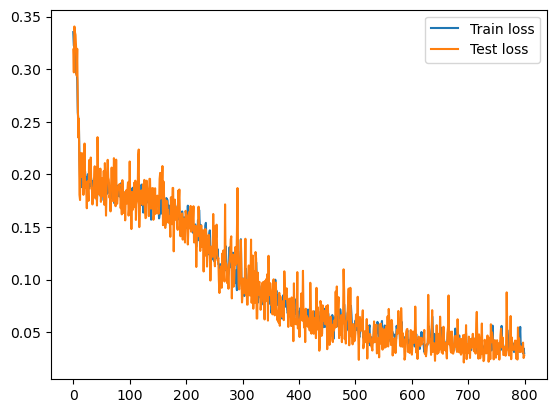

In [170]:
## Plot the losses

plt.plot(train_losses, label = "Train loss")
plt.plot(test_losses, label = "Test loss")
plt.legend()
plt.show()

In [175]:
## Plot a few guesses.

model.eval()
with torch.no_grad():
    batch = next(iter(test_dataloader))
    batch = batch.to(device)
    noise_level = 4
    T = sde.get_closest_timestep(noise_level)
    if len(batch.shape) == 3:
        batch = batch.unsqueeze(1)
    timesteps = T.repeat(batch.shape[0],1).to(device)
    ps_tensor, phi = ps_sampler.sample_ps(batch.shape[0])
    batch_tilde, _ , _ = sde.sampling(batch, timesteps, torch.sqrt(ps_tensor))
    rphi = ps_sampler.rescale_phi(phi)
    out = model.network(batch_tilde, timesteps)
    residual = (out - rphi).cpu()

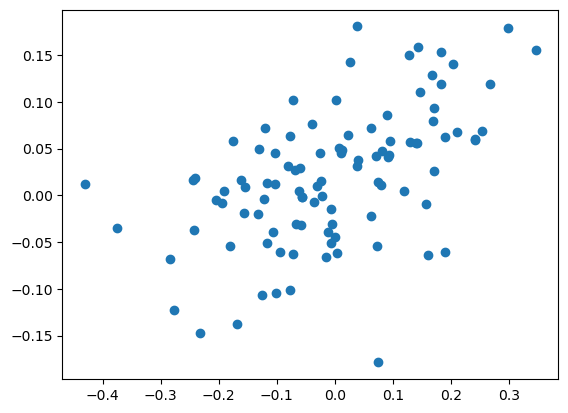

In [176]:
plt.scatter(residual[:,0], residual[:,1])
plt.show()

In [99]:
## Train a second order model

network2 = TparamMomentNetwork( in_channels = 1, dim_param = 2, in_size = 32, order = 2, num_blocks = 3, first_channels = 10, time_embed_dim = 100,padding_mode="circular", 
         normalize="GN", group_c=1, skiprescale = True, discretization = "continuous", embedding_mode = None, n_steps = 1000,dropout=0.0)

network2 = network2.to(device)

In [100]:
model2 = MomentModel(network2, sde, ps_sampler, conetwork = network)

optimizer2 = torch.optim.AdamW(model2.parameters(), lr=1e-3)

epochs = 1200

In [101]:
train_losses2, test_losses2 = train(model2, optimizer2, train_dataloader, epochs = 400,test_dataloader = test_dataloader, ckpt_path = CKPT_DIR, ckpt_step = 5)

  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

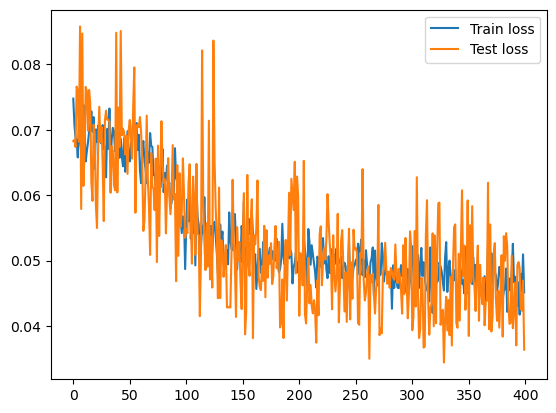

In [74]:
## Plot the losses

plt.plot(train_losses2, label = "Train loss")
plt.plot(test_losses2, label = "Test loss")
plt.legend()

In [118]:
rphi_0_grid = torch.linspace(-1, 1, 10)
rphi_1_grid = torch.linspace(-1, 1, 10)

rphi_0_grid, rphi_1_grid = torch.meshgrid(rphi_0_grid, rphi_1_grid)

rphi_grid = torch.stack([rphi_0_grid, rphi_1_grid], dim = -1)

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /dev/shm/nix-build-py-torch-2.0.1.drv-2/nixbld2/spack-stage-py-torch-2.0.1-mz6i5h51yxg23diix2nxgr73s62pzclc/spack-src/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [120]:
rphi_grid = rphi_grid.reshape(-1,2)

In [121]:
rphi_grid_list = rphi_grid.split(1)

In [145]:
model.eval()
model2.eval()
rphi_0_grid = torch.linspace(-1, 1, 100)
results = []
for rphi_0 in rphi_0_grid:
    batch = next(iter(test_dataloader))
    batch = batch.to(device)
    noise_level = 0.01
    T = sde.get_closest_timestep(noise_level)
    if len(batch.shape) == 3:
        batch = batch.unsqueeze(1)
    timesteps = T.repeat(batch.shape[0],1).to(device)
    rphi_test = torch.tensor([rphi_0, 0.0]).to(device).reshape(1,2).repeat(batch.shape[0],1)
    phi_test = ps_sampler.unscale_phi(rphi_test)
    ps_test = ps_sampler(rphi_test)
    batch_tilde, _ , _ = sde.sampling(batch, timesteps, torch.sqrt(ps_test))
    mean = model.network(batch_tilde, timesteps)
    results.append(mean.cpu().detach().numpy())
    break

In [146]:
ps_test.mean()

tensor(1.6686e+10, device='cuda:0', grad_fn=<MeanBackward0>)

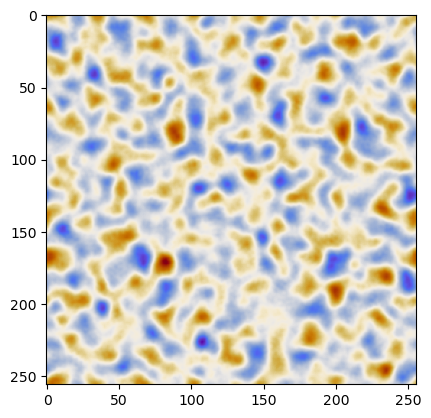

In [143]:
plt.imshow(batch_tilde[0,0].cpu().detach().numpy(), cmap = "cmb")

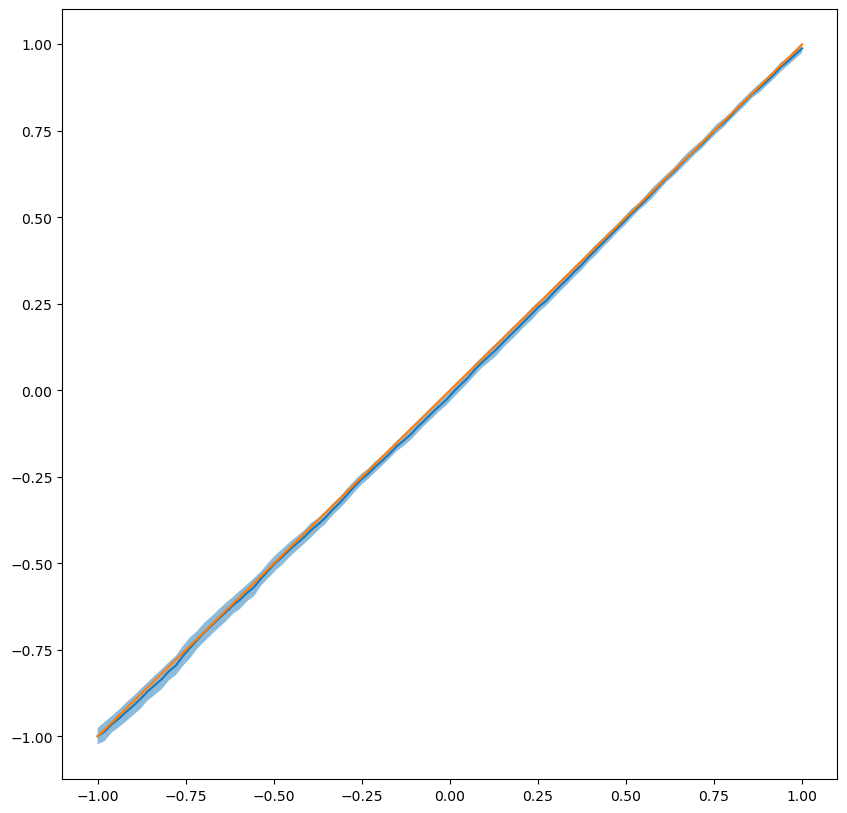

In [136]:
## Plot the results. Plot the mean of the model as a function of the true mean (for rphi_0)

fig, ax = plt.subplots(figsize = (10,10))

results = [res.reshape(1,100,2) for res in results]
results = np.concatenate(results, axis = 0)

ax.plot(rphi_0_grid, results[:, :, 0].mean(axis = 1), label = "Model mean")
ax.fill_between(rphi_0_grid, results[:, :, 0].mean(axis = 1) - results[:, :, 0].std(axis = 1), results[:, :, 0].mean(axis = 1) + results[:, :, 0].std(axis = 1), alpha = 0.5)
ax.plot(rphi_0_grid, rphi_0_grid, '-' ,label = "True mean")

In [116]:
## Sample one phi, build some noisy x and compute the estimated mean and covariance matrix of the posterior given x

model.eval()
model2.eval()

with torch.no_grad():
    batch = next(iter(test_dataloader))
    batch = batch.to(device)
    noise_level = 0.02
    T = sde.get_closest_timestep(noise_level)
    if len(batch.shape) == 3:
        batch = batch.unsqueeze(1)
    timesteps = T.repeat(batch.shape[0],1).to(device)
    ps_tensor, phi = ps_sampler.sample_ps(batch.shape[0])
    batch_tilde, _ , _ = sde.sampling(batch, timesteps, torch.sqrt(ps_tensor))
    rphi = ps_sampler.rescale_phi(phi)
    mean = model.network(batch_tilde, timesteps)
    cov = model2.network(batch_tilde, timesteps)
rphi = rphi.cpu()
mean = mean.cpu()
cov = cov.cpu()

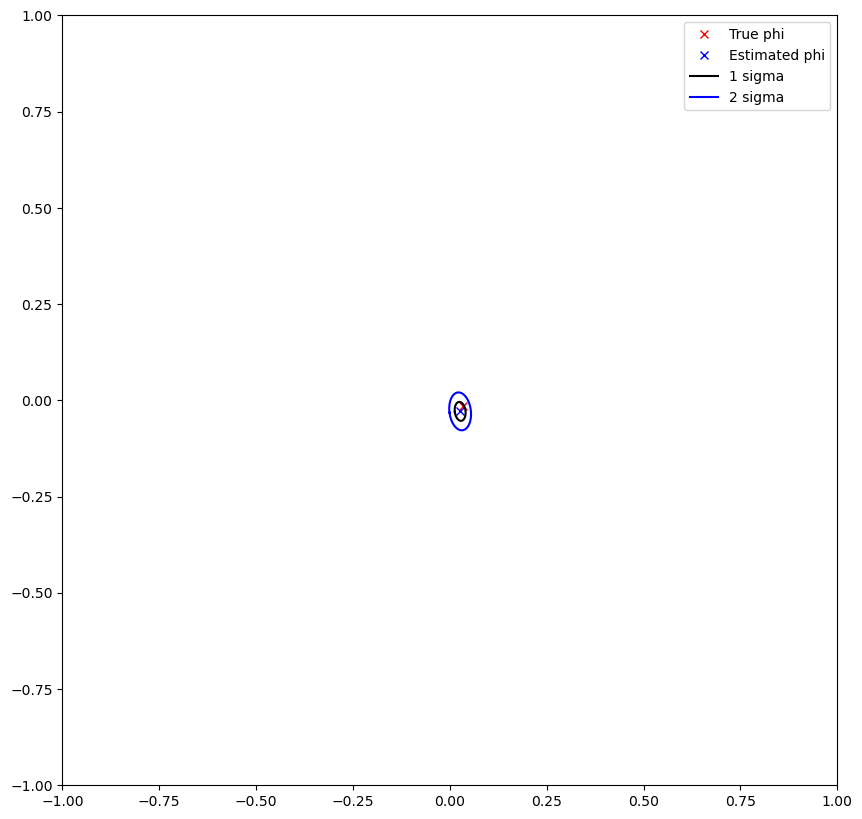

In [117]:
idx = 0

## Plot a 2D image with a red cross at the true value of phi and a blue cross at the estimated value of phi and two ellipses corresponding to 1 sigma and 2 sigma confidence intervals
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.plot(rphi[idx,0], rphi[idx,1], 'rx', label = "True phi")
ax.plot(mean[idx,0], mean[idx,1], 'bx', label = "Estimated phi")

## Get the points to plot the ellipses
thetas = np.linspace(0, 2*np.pi, 100)
x = np.cos(thetas)
y = np.sin(thetas)
points = np.vstack((x,y)).T

## Compute the eigenvalues and eigenvectors of the covariance matrix

eigvals, eigvecs = np.linalg.eig(cov[idx].cpu().numpy())

## Plot the 1 sigma ellipse

ellipse = np.sqrt(eigvals[0])*np.outer(points[:,0], eigvecs[:,0]) + np.sqrt(eigvals[1])*np.outer(points[:,1], eigvecs[:,1])
ax.plot(ellipse[:,0] + mean[idx,0].item(), ellipse[:,1] + mean[idx,1].item(), 'black', label = "1 sigma")

## Plot the 2 sigma ellipse

ellipse = 2*np.sqrt(eigvals[0])*np.outer(points[:,0], eigvecs[:,0]) + 2*np.sqrt(eigvals[1])*np.outer(points[:,1], eigvecs[:,1])
ax.plot(ellipse[:,0] + mean[idx,0].item(), ellipse[:,1] + mean[idx,1].item(), 'b', label = "2 sigma")
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.legend()